In [2]:
#Step 1 : Preprocessing audio and transcripting
import os
import torch
import torchaudio
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor

AUDIO_DIR = "dataset/audio"
TRANSCRIPT_DIR = "dataset/transcripts"
os.makedirs(TRANSCRIPT_DIR, exist_ok=True)

print("Loading Wav2Vec2.0")
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")
model.eval()

def transcribe_audio(audio_path):
    waveform, sample_rate = torchaudio.load(audio_path)
    if waveform.shape[0] > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)
    if sample_rate != 16000:
        resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
        waveform = resampler(waveform)
    input_values = processor(waveform.squeeze().numpy(), return_tensors="pt", sampling_rate=16000).input_values
    with torch.no_grad():
        logits = model(input_values).logits
    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = processor.decode(predicted_ids[0])

    return transcription.lower()

print("Transcribing")
for filename in sorted(os.listdir(AUDIO_DIR)):
    if filename.endswith(".wav"):
        audio_path = os.path.join(AUDIO_DIR, filename)
        transcript = transcribe_audio(audio_path)

        base_name = os.path.splitext(filename)[0]
        with open(os.path.join(TRANSCRIPT_DIR, base_name + ".txt"), "w") as f:
            f.write(transcript)

        print(f"[Done] {filename} → {transcript}")


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


Loading Wav2Vec2.0
Ignored unknown kwarg option normalize
Ignored unknown kwarg option normalize
Ignored unknown kwarg option normalize
Ignored unknown kwarg option normalize


Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_v', 'wav2vec2.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You sho

Transcribing
[Done] AbeBurrows_5.wav → flist to me bob was he was worried when i became a performer he was a worried that i would do what he did he  he gave hime a long storicress once he started to act he stopped riting bob told me story he says hestopped riting gave up his typewriter and the herl tribune he told me story once to the hel tribune had an editorial that bob benchley is giving up his typewrider and bob said you know it that i got madi that i got about a hundred letters asking for the typewright but he walked up to me the party one day and he says could you rite a song for me called two little words i love you and i wrote such a song and we we became very good friends he was modest me but he was one who chiefly encouraged me to stay with riding and not just you know when i was acting when i was performing i i after while my clubs i stopped creating for a while is tust  ris yor son sasn't well what you doin night clubsunoltils you begin to do the sure things your best thing

In [3]:
!pip install fairseq

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 49.0 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 110.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.4/112.4 kB 97.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 166.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.3/299.3 kB 180.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 125.5 MB/s eta 0:00:00a 0:00:01
  Created wheel for fairseq: filename=fairseq-0.12.2-cp310-cp310-linux_x86_64.whl size=11288699 sha256=899c583f93c125abdabf53cf3

In [7]:
#Step 2 : Extracting relevant features
import os
import re
import librosa
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

AUDIO_DIR = "dataset/audio"
TRANSCRIPT_DIR = "dataset/transcripts"
GLOVE_PATH = "glove.6B.100d.txt"
def load_glove_model(glove_file):
    embeddings = {}
    with open(glove_file, encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split()
            word = parts[0]
            vec = np.array(parts[1:], dtype=np.float32)
            embeddings[word] = vec
    return embeddings

glove = load_glove_model(GLOVE_PATH)

def compute_semantic_anomaly(text, model):
    words = text.lower().split()
    vectors = [model[w] for w in words if w in model]
    if len(vectors) < 2:
        return 0
    vectors = np.array(vectors)
    mean_vec = np.mean(vectors, axis=0).reshape(1, -1)
    sim = cosine_similarity(vectors, mean_vec)
    return 1 - np.mean(sim)

def count_hesitations(text):
    return len(re.findall(r'\b(uh|um|erm|eh|hmm|ah)\b', text.lower()))

def calc_speech_rate(text, duration_sec):
    word_count = len(text.split())
    return word_count / duration_sec if duration_sec > 0 else 0

def calc_pitch_variability(audio_path):
    y, sr = librosa.load(audio_path, sr=None)
    pitches, _ = librosa.piptrack(y=y, sr=sr)
    pitch_values = pitches[pitches > 0]
    return np.std(pitch_values) if len(pitch_values) > 0 else 0

def count_vague_words(text):
    vague_words = ['thing', 'stuff', 'something', 'somewhere']
    return sum(text.lower().split().count(w) for w in vague_words)

def is_incomplete_sentence(text):
    endings = ["and", "but", "then", ","]
    words = text.lower().split()
    return 1 if len(words) < 4 or text.strip().endswith(tuple(endings)) else 0

def count_lost_words(text):
    return len(re.findall(r'\b(that thing|you know|like)\b', text.lower()))

def load_data():
    data = []
    for file in sorted(os.listdir(TRANSCRIPT_DIR)):
        if file.endswith(".txt"):
            file_id = file.replace(".txt", "")
            with open(os.path.join(TRANSCRIPT_DIR, file)) as f:
                text = f.read().strip()
            audio_path = os.path.join(AUDIO_DIR, file_id + ".wav")
            duration = librosa.get_duration(path=audio_path)
            data.append((file_id, text, audio_path, duration))
    return data

print("Feature Extraction")

raw_data = load_data()
results = []

for file_id, text, audio_path, duration in raw_data:
    features = {
        "file": file_id,
        "hesitation_count": count_hesitations(text),
        "pause_count": count_hesitations(text),
        "speech_rate": calc_speech_rate(text, duration),
        "pitch_variability": calc_pitch_variability(audio_path),
        "semantic_anomaly": compute_semantic_anomaly(text, glove),
        "vague_word_count": count_vague_words(text),
        "incomplete_sentence": is_incomplete_sentence(text),
        "lost_words": count_lost_words(text)
    }
    results.append(features)

df = pd.DataFrame(results)
df.to_csv("features.csv", index=False)
print("saved features.csv")


Feature Extraction
saved features.csv


                  file dbscan_risk_label
0         JackHanna_10           At Risk
1     JimmyFratianno_0            Normal
2      RobinWilliams_0           At Risk
3     SteveLawrence_15            Normal
4  aileenhernandez_5_2            Normal
5        antonyflew_10           At Risk
6         daningram_15           At Risk
7      georgeklein_5_2           At Risk
8       paulhornung_10            Normal
9         terryjones_5           At Risk


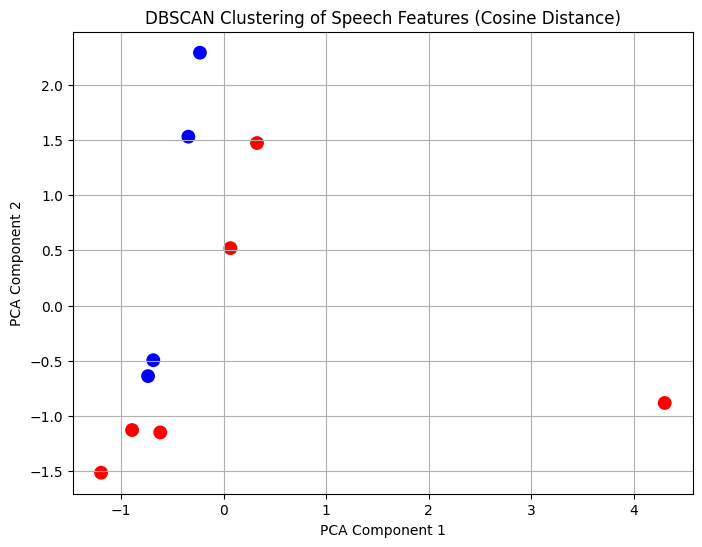

In [8]:
#Step 3 : Unsupervised ML approach
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_distances

df = pd.read_csv("features.csv")

feature_cols = [
    "hesitation_count", "pause_count", "speech_rate", "pitch_variability",
    "semantic_anomaly", "vague_word_count", "incomplete_sentence", "lost_words"
]

X = df[feature_cols]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

cosine_dist = cosine_distances(X_scaled)

db = DBSCAN(eps=0.3, min_samples=2, metric="precomputed")
df['dbscan_cluster'] = db.fit_predict(cosine_dist)

df['dbscan_risk_label'] = df['dbscan_cluster'].apply(lambda x: 'At Risk' if x == -1 else 'Normal')

df.to_csv("clustered_results_dbscan.csv", index=False)
print(df[["file", "dbscan_risk_label"]])

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
colors = ['red' if label == -1 else 'blue' for label in df['dbscan_cluster']]
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=colors, s=80)
plt.title("DBSCAN Clustering of Speech Features (Cosine Distance)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.savefig("dbscan_clustering_plot.png")
plt.show()